# Sea ice time series

Southern hemisphere september sea ice extent.

In [2]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)

def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load simulations

In [3]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0000-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])



fs = 15

alpha_res = 2.
p_res = 50

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='04:00:00')
    cluster.scale(nw)
    client = Client(cluster)

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/35633/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/35633/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:40283,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/35633/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time
res_funcs = []

for i in range(num_sims):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))
    Rd_dx = sim.ds.Rd_dx.mean('time').compute()

    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)


Opened 732 files (0000-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 732 files (0000-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 732 files (0000-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 732 files (0000-0061, match='h.native')
Opened grid and assigned coordinates.
CPU times: user 2min 10s, sys: 12 s, total: 2min 22s
Wall time: 5min 12s


### Find sea ice extent

In [6]:
%%time
ice_areas_south = []
ice_areas_north = []

for i in range(num_sims):
    sim = sims[i]
    sim.open_files_by_year(sim.ice_data_path, "", start_year, end_year)
    ice_area = sim.ds.aice*sim.ds.tarea
    total_ice_area = ice_area.where(sim.ds.TLAT<0).sum(axis=(-1,-2))
    ice_areas_south.append(total_ice_area)
    total_ice_area = ice_area.where(sim.ds.TLAT>0).sum(axis=(-1,-2))
    ice_areas_north.append(total_ice_area)

Opened 732 files (0000-0061)
Opened 732 files (0000-0061)
Opened 732 files (0000-0061)
Opened 732 files (0000-0061)
CPU times: user 2min 50s, sys: 14.1 s, total: 3min 4s
Wall time: 4min 2s


CPU times: user 40.4 s, sys: 1.49 s, total: 41.9 s
Wall time: 2min 20s


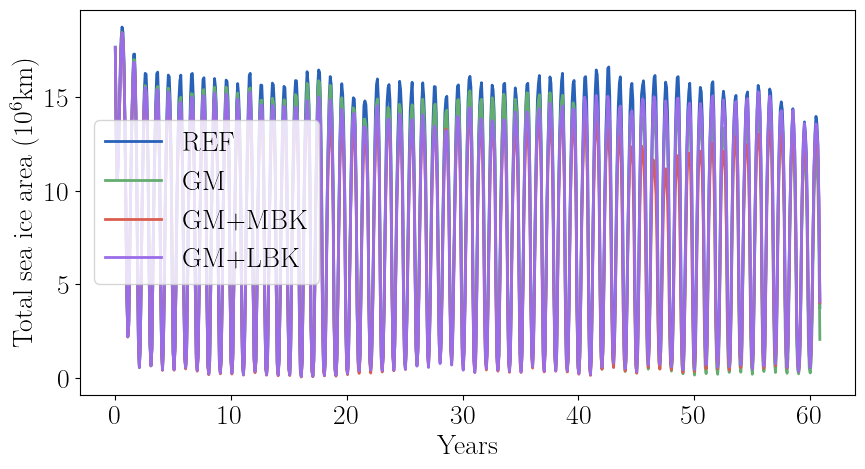

In [7]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale

for i in range(num_sims):
    sim=sims[i]
    time = sim.ds.time
    field = ice_areas_south[i]/1000**2/1e6
    # Convert time coordinate to days
    days = (time - time[0]).astype('timedelta64').astype(float)
    days /= (1e9*3600*24*365.25)
    ax.plot(days, field, label=snames[i],c=c[i],lw=2)

ax.set_xlabel('Years')
ax.set_ylabel('Total sea ice area ($10^6 \mathrm{km}$)')
title = 'Ice Area SH'

ax.tick_params(axis='both', which='major')

ax.legend()
#ax.grid()

plt.savefig(save_path+title+'legend.png',dpi=300)

CPU times: user 40.2 s, sys: 1.65 s, total: 41.9 s
Wall time: 2min 16s


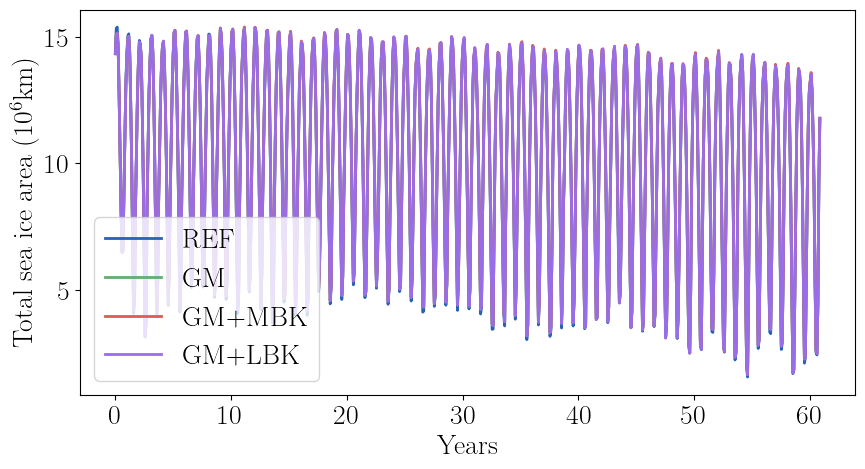

In [8]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale

for i in range(num_sims):
    sim=sims[i]
    time = sim.ds.time
    field = ice_areas_north[i]/1000**2/1e6
    # Convert time coordinate to days
    days = (time - time[0]).astype('timedelta64').astype(float)
    days /= (1e9*3600*24*365.25)
    ax.plot(days, field, label=snames[i],c=c[i],lw=2)

ax.set_xlabel('Years')
ax.set_ylabel('Total sea ice area ($10^6 \mathrm{km}$)')
title = 'Ice Area NH'

ax.tick_params(axis='both', which='major')

ax.legend()
#ax.grid()

plt.savefig(save_path+title+'legend.png',dpi=300)

### Northern hemisphere sea ice extent in September

CPU times: user 3.26 s, sys: 120 ms, total: 3.38 s
Wall time: 11.5 s


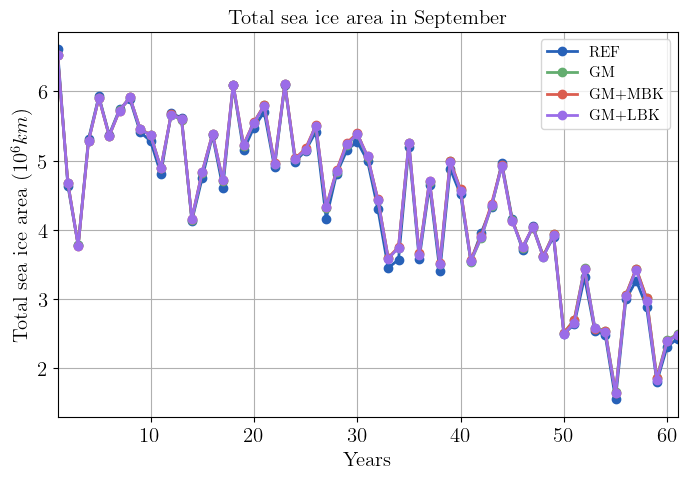

In [9]:
%%time
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)

for i in range(num_sims):
    sim=sims[i]
    ice_area = ice_areas_north[i]
    time = [i+1 for i in range(ice_area.shape[0]//12)] #sim.ds.time
    september_ice_area = ice_area.sel(time=ice_area.time.dt.month == 9)
    
    field = september_ice_area/1000**2/1e6
    # Convert time coordinate to days
    #days = (time - time[0]).astype('timedelta64').astype(float)
    #days /= (1e9*3600*24*365.25)
    ax.plot(time, field, label=snames[i],c=c[i],lw=2,marker='o')

ax.set_xlabel('Years',fontsize=fs)
ax.set_ylabel('Total sea ice area ($10^6 km$)',fontsize=fs)
title = 'Total sea ice area in September'
ax.set_title(title,fontsize=fs)
#ax.set_ylim([0.0e18, 5.0e18])
ax.set_xlim([1, 61])

ax.tick_params(axis='both', which='major', labelsize=fs)
#ax.tick_params(axis='both', which='minor', labelsize=8)

ax.legend(loc='best',fontsize=int(0.75*fs))
ax.grid()
plt.savefig(save_path+title+'NH.png',dpi=300)   

### Southern hemisphere sea ice extent in September

CPU times: user 3.1 s, sys: 124 ms, total: 3.22 s
Wall time: 9.37 s


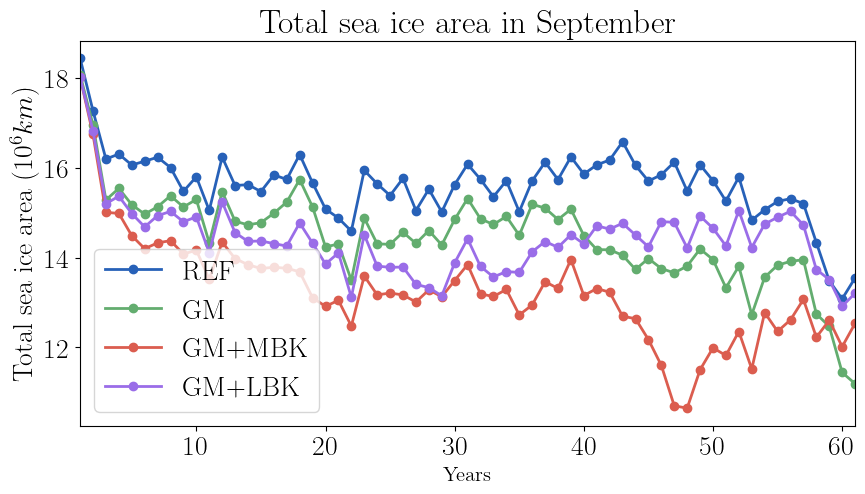

In [10]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

for i in range(num_sims):
    sim=sims[i]
    ice_area = ice_areas_south[i]
    time = [i+1 for i in range(ice_area.shape[0]//12)] #sim.ds.time
    september_ice_area = ice_area.sel(time=ice_area.time.dt.month == 9)
    
    field = september_ice_area/1000**2/1e6
    # Convert time coordinate to days
    #days = (time - time[0]).astype('timedelta64').astype(float)
    #days /= (1e9*3600*24*365.25)
    ax.plot(time, field, label=snames[i],c=c[i],lw=2,marker='o')

ax.set_xlabel('Years',fontsize=fs)
ax.set_ylabel('Total sea ice area ($10^6 km$)')
title = 'Total sea ice area in September'
ax.set_title(title)
#ax.set_ylim([0.0e18, 5.0e18])
ax.set_xlim([1, 61])

ax.tick_params(axis='both', which='major',)

ax.legend()
#ax.grid()
plt.savefig(save_path+title+'SH.png',dpi=300)   

CPU times: user 2.96 s, sys: 114 ms, total: 3.07 s
Wall time: 8.47 s


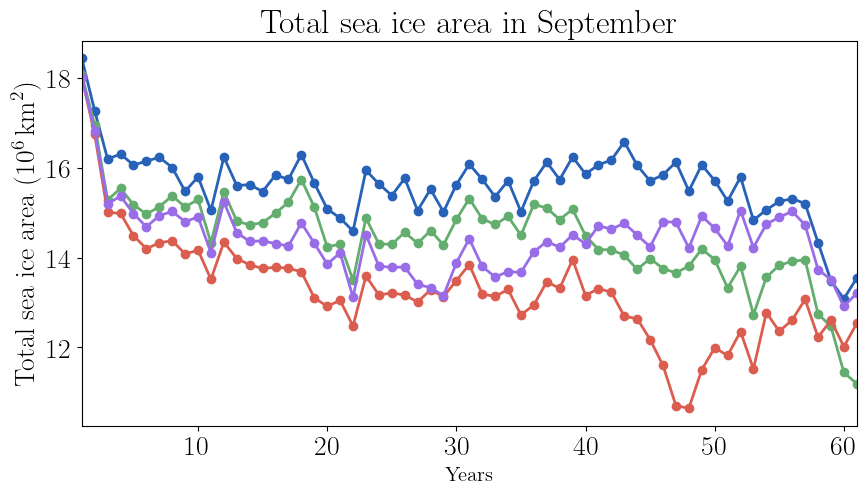

In [11]:
%%time
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

for i in range(num_sims):
    sim=sims[i]
    ice_area = ice_areas_south[i]
    time = [i+1 for i in range(ice_area.shape[0]//12)] #sim.ds.time
    september_ice_area = ice_area.sel(time=ice_area.time.dt.month == 9)
    
    field = september_ice_area/1000**2/1e6
    # Convert time coordinate to days
    #days = (time - time[0]).astype('timedelta64').astype(float)
    #days /= (1e9*3600*24*365.25)
    ax.plot(time, field, label=snames[i],c=c[i],lw=2,marker='o')

ax.set_xlabel('Years',fontsize=fs)
ax.set_ylabel('Total sea ice area ($10^6 \, \mathrm{km}^2$)')
title = 'Total sea ice area in September'
ax.set_title(title)
#ax.set_ylim([0.0e18, 5.0e18])
ax.set_xlim([1, 61])

ax.tick_params(axis='both', which='major',)

#ax.legend()
#ax.grid()
plt.savefig(save_path+title+'SH no legend.png',dpi=300)   